In [ ]:
!pip install pandas openpyxl --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [ ]:
#1 Load & Clean
assets      = pd.read_excel('Balance_Sheet.xlsx', sheet_name="ASSETS").replace("-", 0)
liabilities = pd.read_excel('Balance_Sheet.xlsx', sheet_name="LIABILITIES").replace("-", 0)
obs         = pd.read_excel('OBS.xlsx').replace("-", 0)
mat_prof    = pd.read_excel('Maturity_Profile.xlsx').replace("-", 0)
earnings    = pd.read_excel("Earnings_Expenses.xlsx", sheet_name = 'EARNINGS').replace("-", 0)
expenses    = pd.read_excel("Earnings_Expenses.xlsx", sheet_name = 'EXPENSES').replace("-", 0)
pnl         = pd.merge(earnings, expenses, on=['Banks','Year'], how='left')
ratios      = pd.read_excel('Ratios_of_SCBs.xlsx').replace("-", 0)



/tmp/ipython-input-105-532170424.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assets      = pd.read_excel('Balance_Sheet.xlsx', sheet_name="ASSETS").replace("-", 0)
/tmp/ipython-input-105-532170424.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liabilities = pd.read_excel('Balance_Sheet.xlsx', sheet_name="LIABILITIES").replace("-", 0)
/tmp/ipython-input-105-532170424.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call 

In [ ]:
#2 Merge into one Sheet
df = (
    assets
    .merge(liabilities, on=["Banks","Year"], how="left")
    .merge(obs,         on=["Banks","Year"], how="left")
    .merge(mat_prof,    on=["Banks","Year"], how="left")
)


In [ ]:
#3 Category Based liquidity Aggregates
df["liq_assets"] = (
      df["1.     Cash in hand"]
    + df["2.     Balances with RBI"]
    + df["3.     Balances with banks in India"]
    + df["4.     Money at call and short notice"]
    + df["5.     Balances with banks outside India"]
    + df["6.1.       Investments in India"]
    + df["6.2.       Investments outside India"]
    - df["(ii)    Subsidiaries and/or joint ventures"]
    - df["(v)    Subsidiaries and/or joint ventures"]
)

df["semiliq_assets"] = (
      df["(ii)        Public sectors"]
    + df["(iii)       Banks"]
)

df["illiq_assets"] = (
      df["(i)         Priority sectors "]
    + df["(ii)    Subsidiaries and/or joint ventures"]
    + df["(v)    Subsidiaries and/or joint ventures"]
    + df["(iv)       others"]
    + df["7C.2.    Advances outside India"]
    + df["8.     Fixed Assets"]
    + df["9.     Other Assets"]
)

df["liq_liab"] = (
      df["1.     Capital"]
    + df["2. Reserves and Surplus"]
    + df["(iii)      From other institutions and agencies"]
    + df["4.2.      Borrowings outside India"]
    + df["5. Other liabilities & provisions"]
    - df["5.1.      Bills Payable"]
)

df["semiliq_liab"] = (
      df["(i)          From banks"]
    + df["3A.3.   Term deposits"]
    + df["(i)        From Reserve Bank of India"]
    + df["(ii)       From other banks"]
)

df["illiq_liab"] = (
      df["5.1.      Bills Payable"]
    + df["(ii)         From others"]
    + df["3A.2.   Savings bank deposits"]
)


In [ ]:
#4 Fat & Non-Fat Indices
df["LC_catnonfat"] = (
      0.5 * df["liq_liab"]
    - 0.5 * df["illiq_liab"]
    + 0.5 * df["illiq_assets"]
    - 0.5 * df["liq_assets"]
)

df['semiliq_obs'] = df['Liability on account of outstanding forward exchange contracts']
df['illiq_obs'] = df['Total'] - df['Liability on account of outstanding forward exchange contracts']
df['LC_catfat'] = 0.5*df['liq_liab'] + 0*df['semiliq_liab'] - 0.5*df['illiq_liab'] + 0.5*df['illiq_assets'] + 0*df['semiliq_assets'] -0.5*df['liq_assets'] + 0*df['semiliq_obs'] + 0.5*df['illiq_obs']


In [ ]:
#5 Maturity Based Indices
df["illiq_assets_mat"] = (
      df["8.     Fixed Assets"]
    + df["9.     Other Assets"]
    + df["(ii)    Subsidiaries and/or joint ventures"]
    + df["(v)    Subsidiaries and/or joint ventures"]
    + df["Loans and Advances f)   Over 1 year to 3 years"]
    + df["Loans and Advances g)  Over 3 years to 5 years"]
    + df["Loans and Advances h)  Over 5 years"]
)

df["semiliq_assets_mat"] = (
      df["Loans and Advances a)  1 - 14 days"]
    + df["Loans and Advances b)  15 - 28 days"]
    + df["Loans and Advances c)  29 days to 3 months"]
    + df["Loans and Advances d)  Over 3 months to 6 months"]
    + df["Loans and Advances e)  Over 6 months to 1 year"]
)

df["LC_matnonfat"] = (
      0.5 * df["liq_liab"]
    - 0.5 * df["illiq_liab"]
    + 0.5 * df["illiq_assets_mat"]
    - 0.5 * df["liq_assets"]
)

df["LC_matfat"] = df["LC_matnonfat"] + 0.5*df['illiq_obs']

In [ ]:
#6 Handle NaNs & Normalize
 #6A: Ensure No NaNs in Total Assets
df = df.dropna(subset=['Total Assets'])

 #6B: Fill NaNs in Original LC Columns
for col in ["LC_catnonfat","LC_catfat","LC_matnonfat","LC_matfat"]:
    df[col] = df[col].fillna(0)

 #6C: Divide by Total Assets, Handle Infs & NaNs
raw_cols = ["LC_catnonfat","LC_catfat","LC_matnonfat","LC_matfat"]
ta_cols  = ["LC_catnonfat_TA","LC_catfat_TA","LC_matnonfat_TA","LC_matfat_TA"]

df[ta_cols] = df[raw_cols].div(df['Total Assets'], axis=0)

df[ta_cols] = df[ta_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

 #6D: Scale in (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
df[['catnonfat_n','catfat_n','matnonfat_n','matfat_n']] = scaler.fit_transform(
    df[ta_cols]
)


In [ ]:
#7 Composite Liquidity Score
df["S_liq_weighted"] = (
      0.25 * df["catnonfat_n"]
    + 0.25 * df["catfat_n"]
    + 0.25 * df["matnonfat_n"]
    + 0.25 * df["matfat_n"]
)

# PCA-based
pca = PCA(n_components=1)
df["S_liq_pca"] = pca.fit_transform(
    df[["catnonfat_n","catfat_n","matnonfat_n","matfat_n"]])


In [ ]:
#8 Save the Dataset
df.to_excel('Financial_Parameters.xlsx', index=False)
print("All financial parameters calculated and full dataset saved as Financial_Parameters.xlsx")

#9 Ensure Year is numeric before proceeding
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

All financial parameters calculated and full dataset saved as Financial_Parameters.xlsx


/tmp/ipython-input-133-820917347.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


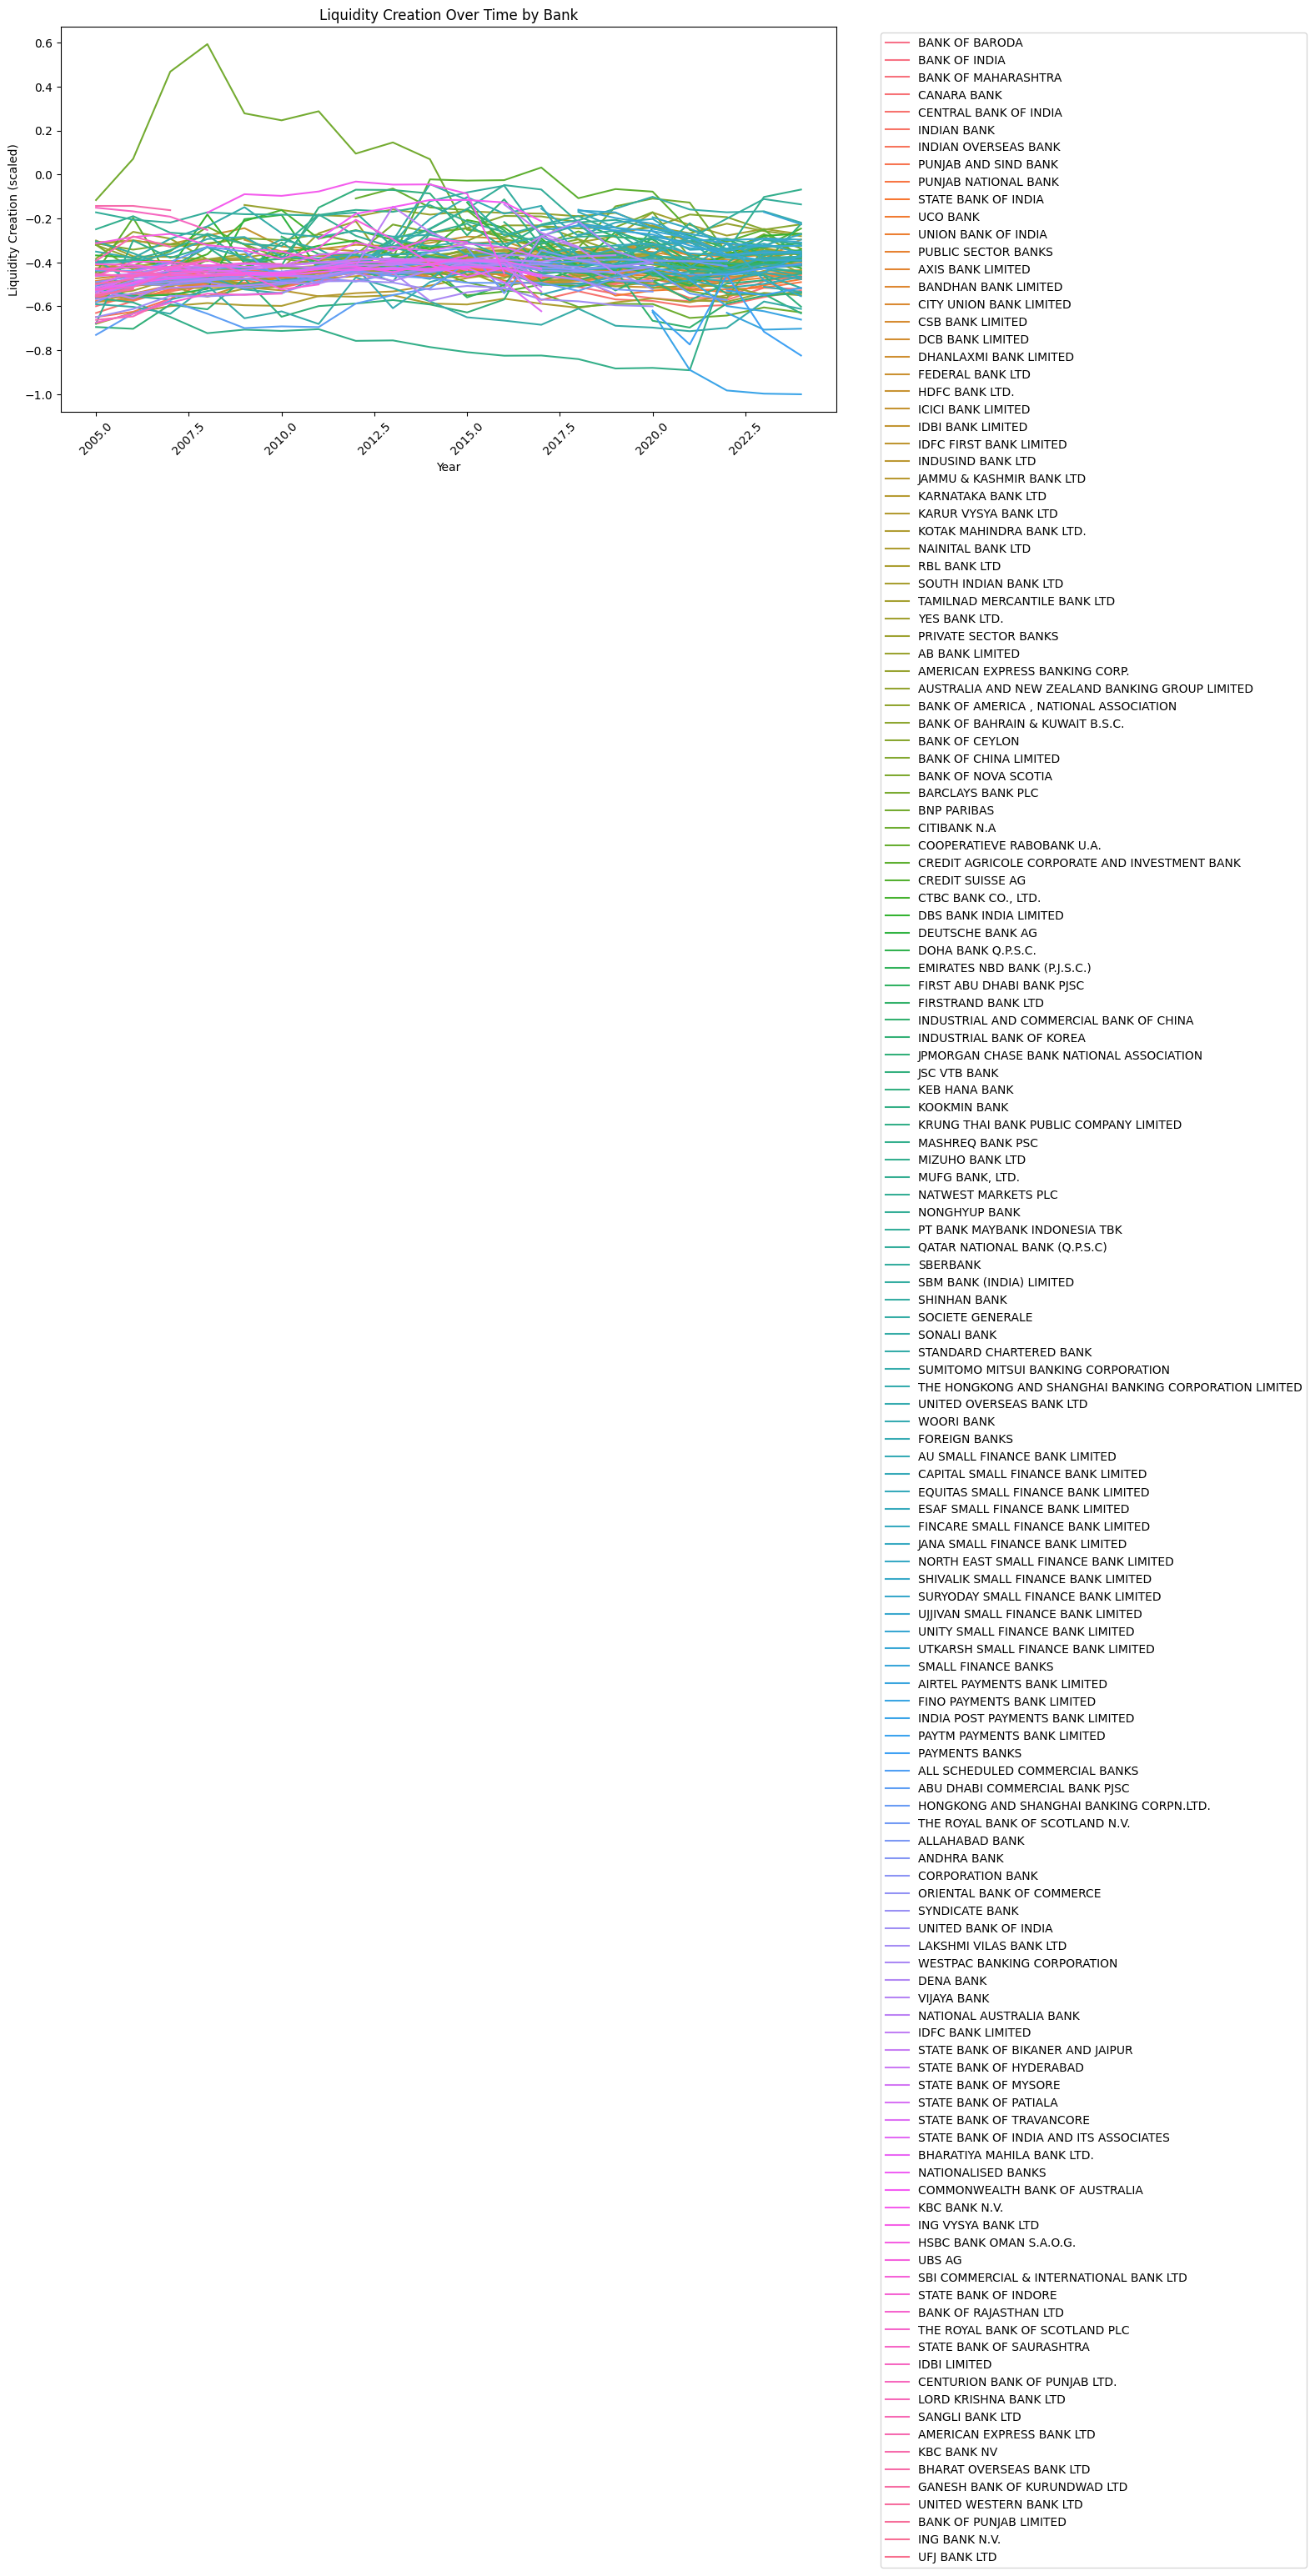

In [ ]:
#10 Line plot — each bank’s trajectory
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='S_liq_weighted', hue='Banks', legend='full')
plt.title("Liquidity Creation Over Time by Bank")
plt.ylabel("Liquidity Creation (scaled)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


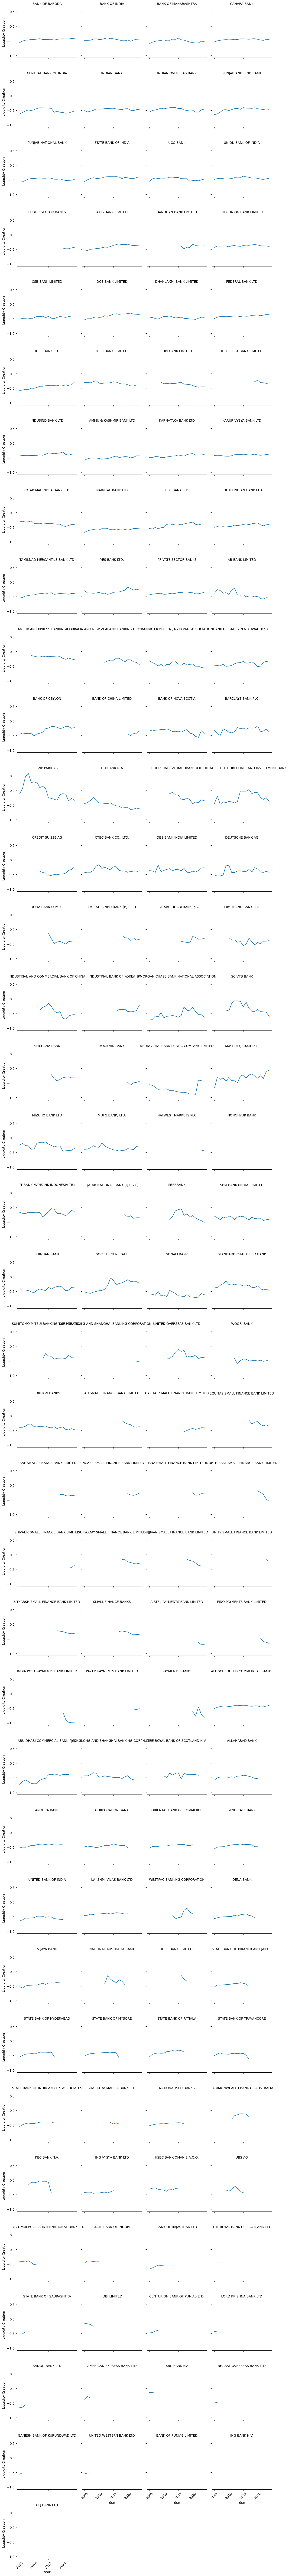

In [ ]:
#11 Faceted small multiples — one panel per bank
g = sns.FacetGrid(df, col="Banks", col_wrap=4, height=3, sharey=True)
g.map_dataframe(sns.lineplot, 'Year', 'S_liq_weighted')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Liquidity Creation")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



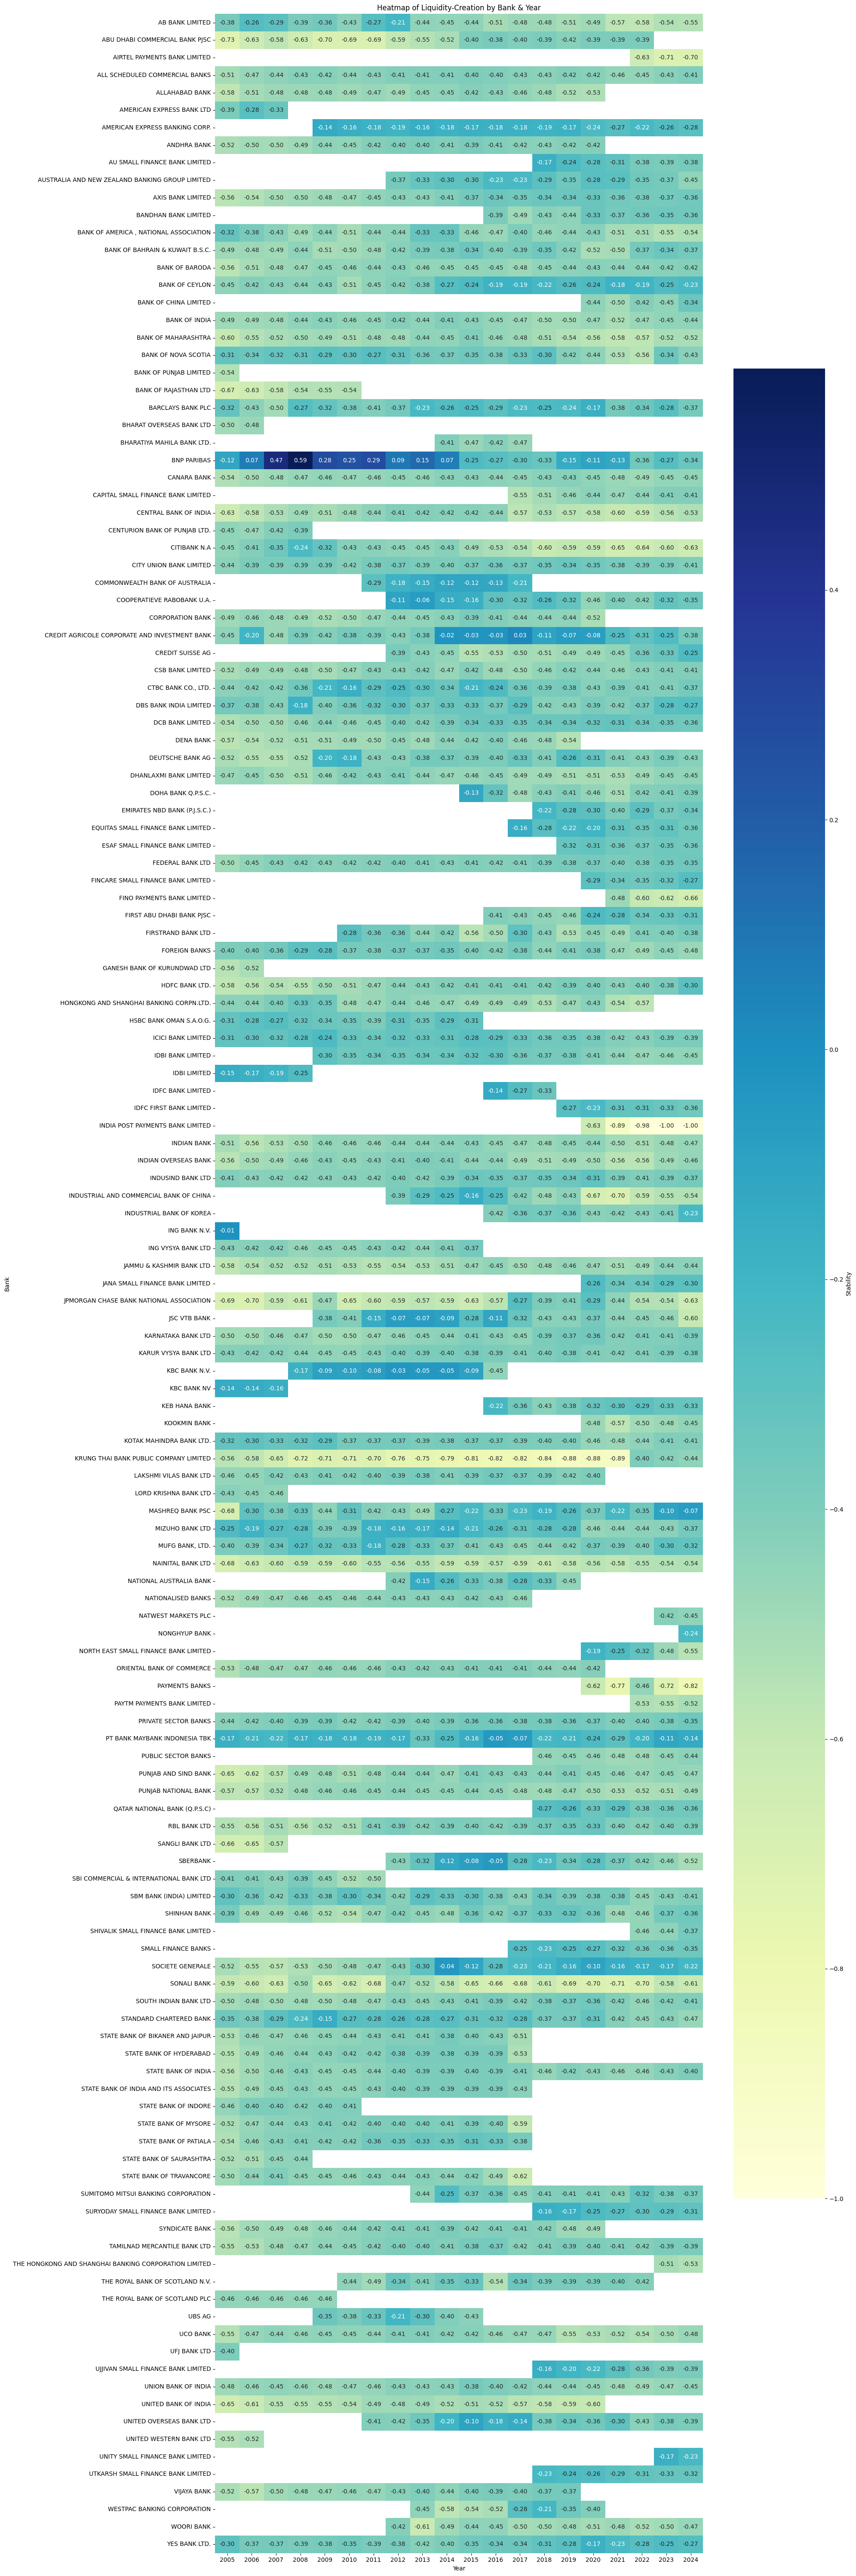

In [ ]:
#12 Heatmap — banks × years matrix with aggregation
pivot = df.pivot_table(index='Banks', columns='Year', values='S_liq_weighted', aggfunc='mean')

plt.figure(figsize=(20,60))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label':'Stability'})
plt.title("Heatmap of Liquidity-Creation by Bank & Year")
plt.ylabel("Bank")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


/tmp/ipython-input-116-3283638749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='S_liq_weighted', palette="vlag")


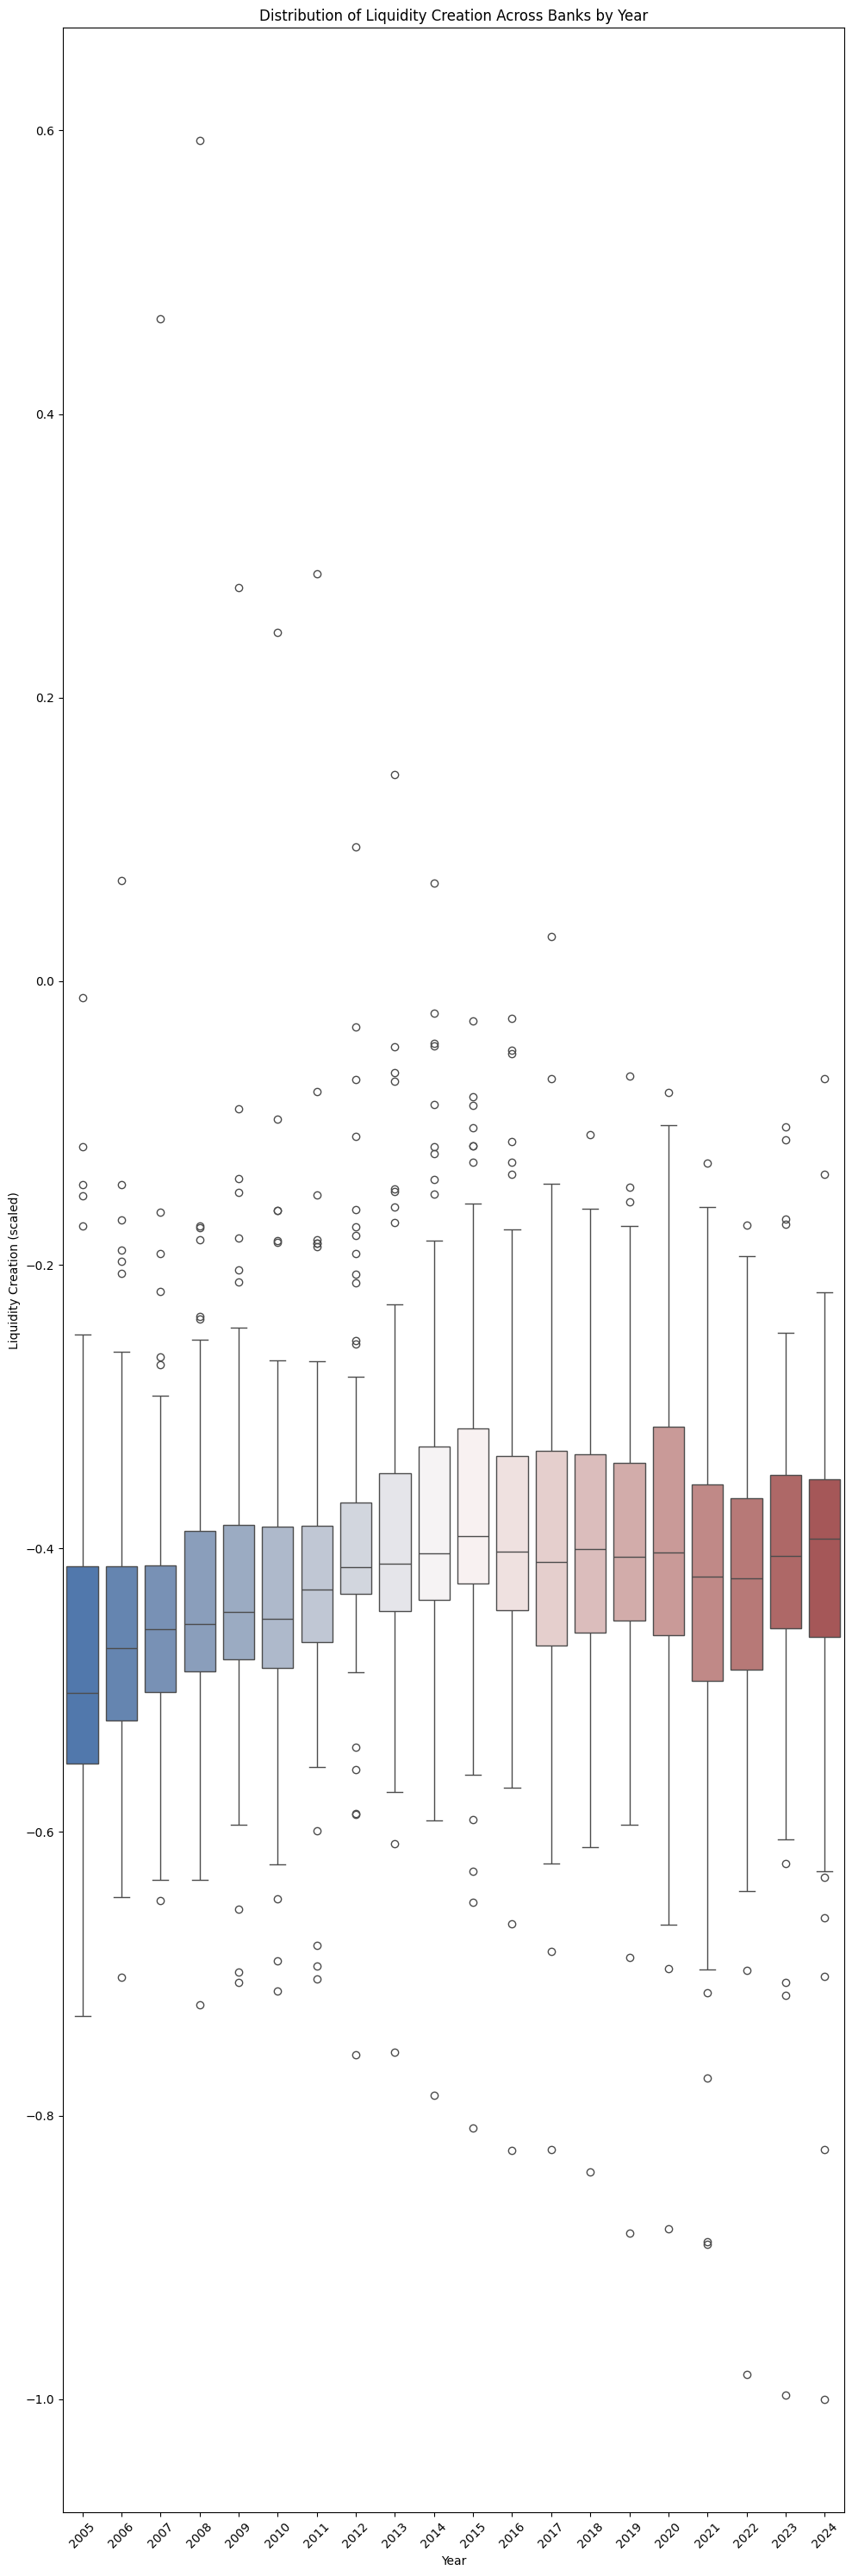

In [ ]:
#13. Boxplot — distribution across banks each year
plt.figure(figsize=(10,30))
sns.boxplot(data=df, x='Year', y='S_liq_weighted', palette="vlag")
plt.title("Distribution of Liquidity Creation Across Banks by Year")
plt.ylabel("Liquidity Creation (scaled)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


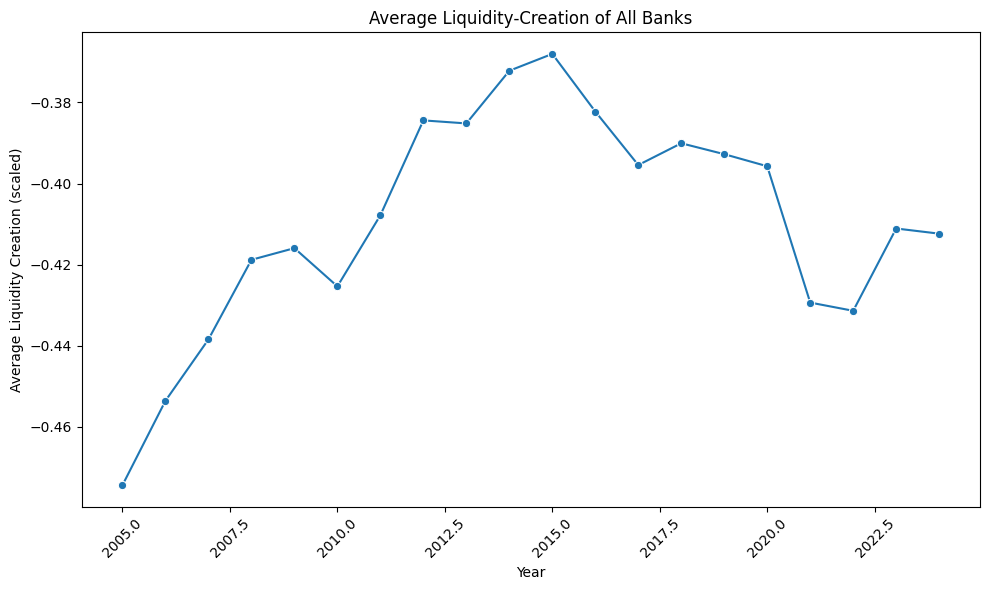

In [ ]:
# 14. Overall trend line — average stability over time
avg = df.groupby('Year')['S_liq_weighted'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=avg, x='Year', y='S_liq_weighted', marker='o')
plt.title("Average Liquidity‑Creation of All Banks")
plt.ylabel("Average Liquidity Creation (scaled)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
#15 Let's Calculate Z-Score
df1 =  pd.merge(df, pnl, on=['Banks','Year'], how='left')
df1


Year                           Banks  1.     Cash in hand  \
0     2024                  BANK OF BARODA            3938.2844   
1     2024                   BANK OF INDIA            2127.0221   
2     2024             BANK OF MAHARASHTRA            1015.6986   
3     2024                     CANARA BANK            3361.2540   
4     2024           CENTRAL BANK OF INDIA            1426.1838   
...    ...                             ...                  ...   
1875  2005         STANDARD CHARTERED BANK             104.5811   
1876  2005  THE ROYAL BANK OF SCOTLAND PLC              45.3025   
1877  2005                    UFJ BANK LTD               0.0256   
1878  2005                   FOREIGN BANKS             345.9404   
1879  2005  ALL SCHEDULED COMMERCIAL BANKS            9644.8483   

      2.     Balances with RBI  3.     Balances with banks in India  \
0                   50901.5490                            1288.1536   
1                   36429.2466                            2439.4785   
2                   20145.6410                              16.3829   
3                   67706.9296                            2141.7120   
4                   21528.5053                              29.2870   
...                        ...                                  ...   
1875                 1098.7147                             185.7116   
1876                  444.7325                              22.2433   
1877                    6.6904                              76.2167   
1878                 6413.0705                            7137.8821   
1879               108430.6342                           39890.1360   

      4.     Money at call and short notice  \
0                                13390.3506   
1                                16607.2803   
2                                 9128.3172   
3                                39526.8209   
4                                    0.0000   
...                                     ...   
1875                                79.3380   
1876                                75.0000   
1877                                67.0000   
1878                              2439.8289   
1879                             37267.3801   

      5.     Balances with banks outside India  6.     Investments  \
0                                   25605.8007         369816.8374   
1                                   25334.1049         227144.4677   
2                                       5.6219          68274.1197   
3                                   38023.0059         357454.4215   
4                                   14623.5204         143923.4863   
...                                        ...                 ...   
1875                                   69.5711          10160.1841   
1876                                    6.3365           3330.5929   
1877                                    3.7261             60.2213   
1878                                 1832.9399          42857.6129   
1879                                18199.3505         869737.0169   

      6.1.       Investments in India  (i)     Government securities  ...  \
0                         353524.3761                    322148.9603  ...   
1                         215887.4254                    199999.0694  ...   
2                          68274.1197                     64282.4851  ...   
3                         354656.0525                    342583.2528  ...   
4                         143875.9978                    112720.8365  ...   
...                               ...                            ...  ...   
1875                       10160.1841                      7577.4978  ...   
1876                        3330.5929                      3156.5579  ...   
1877                          60.2213                        40.9333  ...   
1878                       42857.6129                     34042.9929  ...   
1879                      854744.1897                    695421.7404  ...   

      IV.Operatin

In [ ]:
# 16. Sort by bank and year
df1 = df1.sort_values(['Banks','Year']).reset_index(drop=True)

# # 2. Shift Total Assets to get prior-year assets
# df1['TA_lag'] = (
#     df1.groupby('Banks')['Total Assets']
#       .shift(1)
# )

# 3. Compute average assets
# df1['AvgAssets'] = (df1['Total Assets'] + df1['TA_lag']) / 2

# 17. Compute ROA
df1['ROA'] = df1['VIII.  Profit (Loss) during the year'] / df1['Total Assets']

# 18. Handle edge‐cases
df1['ROA'] = df1['ROA'].replace([np.inf, -np.inf], np.nan)
df1['ROA'] = df1['ROA'].fillna(0)   # or dropna, depending on your preference


In [ ]:
#19 Calculate Rolling stddev Calculation
df1 = df1.sort_values(by=['Banks', 'Year'], ascending=[True, True])
df1['ROA_std'] = df1.groupby('Banks')['ROA'].rolling(window=3).std().reset_index(level=0, drop=True)
df1['deposit_growth_rate'] = df1.groupby('Banks')['3. Deposits'].pct_change() * 100
df1 = df1.sort_index()

/tmp/ipython-input-120-1480641547.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df1['deposit_growth_rate'] = df1.groupby('Banks')['3. Deposits'].pct_change() * 100


In [ ]:
#20 Ultimate Z-Score Calculation
df1['Z-score'] = np.log((df1['ROA'] + (df1['1.     Capital'] + df1['2. Reserves and Surplus'])/df1['Total Assets'])/df1['ROA_std'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#21 Let's Calculate Market-Share & HHI
df2 = df1.copy()
df2 = pd.merge(ratios,df2, on=['Banks','Year'], how='left')
df2

Year                           Banks  1.  Cash - Deposit Ratio  \
0     2024                  BANK OF BARODA                  4.132749   
1     2024                   BANK OF INDIA                  5.224992   
2     2024             BANK OF MAHARASHTRA                  7.815904   
3     2024                     CANARA BANK                  5.415269   
4     2024           CENTRAL BANK OF INDIA                  5.962082   
...    ...                             ...                       ...   
1769  2005                SOCIETE GENERALE                  5.525170   
1770  2005                     SONALI BANK                 18.126205   
1771  2005         STANDARD CHARTERED BANK                  5.342700   
1772  2005  THE ROYAL BANK OF SCOTLAND PLC                  6.974612   
1773  2005                    UFJ BANK LTD                  9.486760   

      2.  Credit - Deposit Ratio  3.  Investment - Deposit Ratio  \
0                      80.317677                       27.869524   
1                      76.315117                       30.781711   
2                      73.958256                       25.216928   
3                      70.987240                       27.237391   
4                      63.220552                       37.381624   
...                          ...                             ...   
1769                   30.235246                      112.682058   
1770                   27.101722                       32.600123   
1771                   88.669310                       45.111781   
1772                  140.001002                       47.403944   
1773                  144.471660                       85.066263   

      4.  (Credit + Investment) - Deposit Ratio  \
0                                    108.187201   
1                                    107.096828   
2                                     99.175185   
3                                     98.224630   
4                                    100.602177   
...                                         ...   
1769                                 142.917303   
1770                                  59.701845   
1771                                 133.781092   
1772                                 187.404946   
1773                                 229.537923   

      5.   Ratio of deposits to total liabilities  \
0                                       83.677656   
1                                       80.859290   
2                                       88.151675   
3                                       87.987314   
4                                       86.195403   
...                                           ...   
1769                                    59.098260   
1770                                    67.723396   
1771                                    60.529615   
1772                                    45.637240   
1773                                    21.849599   

      6.   Ratio of demand & savings bank deposits to total deposits  \
0                                             38.762817                
1                                             37.177016                
2                                             52.733179                
3                                             29.900571                
4                                             50.045098                
...                                                 ...                
1769                                           4.706927                
1770                                          74.476640                
1771                                          46.181797                
1772                                          57.959515                
1773                                          58.731322                

      7.   Ratio of priority sector advances to total advances  \
0                                             27.319925          
1                                             29.995378          
2          

In [ ]:
#22 Checking Column Names
for i in df2.columns:
    print(i)

Year
Banks
1.  Cash - Deposit Ratio
2.  Credit - Deposit Ratio
3.  Investment - Deposit Ratio
4.  (Credit + Investment) - Deposit Ratio
5.   Ratio of deposits to total liabilities
6.   Ratio of demand & savings bank deposits to total deposits
7.   Ratio of priority sector advances to total advances
8.   Ratio of term loans to total advances
9.   Ratio of secured advances to total advances
10.  Ratio of investments in non-approved securities to total investments
11.  Ratio of interest income to total assets
12.  Ratio of net interest income to total assets (Net Interest Margin)
13.  Ratio of non-interest income to total assets
14.  Ratio of intermediation cost to total assets
15.  Ratio of wage bills to intermediation cost
16.  Ratio of wage bills to total expense
17.  Ratio of wage bills to total income
18.  Ratio of burden to total assets
19.  Ratio of burden to interest income
20.  Ratio of operating profits to total assets
21.  Return on assets
22.  Return on equity
23.  Cost of dep

In [ ]:
#23 Market-Share Calculation
df2['market_share'] = df2.groupby('Year')['3. Deposits'].transform(lambda x:(100*x) / x.sum())
df2

Year                           Banks  1.  Cash - Deposit Ratio  \
0     2024                  BANK OF BARODA                  4.132749   
1     2024                   BANK OF INDIA                  5.224992   
2     2024             BANK OF MAHARASHTRA                  7.815904   
3     2024                     CANARA BANK                  5.415269   
4     2024           CENTRAL BANK OF INDIA                  5.962082   
...    ...                             ...                       ...   
1769  2005                SOCIETE GENERALE                  5.525170   
1770  2005                     SONALI BANK                 18.126205   
1771  2005         STANDARD CHARTERED BANK                  5.342700   
1772  2005  THE ROYAL BANK OF SCOTLAND PLC                  6.974612   
1773  2005                    UFJ BANK LTD                  9.486760   

      2.  Credit - Deposit Ratio  3.  Investment - Deposit Ratio  \
0                      80.317677                       27.869524   
1                      76.315117                       30.781711   
2                      73.958256                       25.216928   
3                      70.987240                       27.237391   
4                      63.220552                       37.381624   
...                          ...                             ...   
1769                   30.235246                      112.682058   
1770                   27.101722                       32.600123   
1771                   88.669310                       45.111781   
1772                  140.001002                       47.403944   
1773                  144.471660                       85.066263   

      4.  (Credit + Investment) - Deposit Ratio  \
0                                    108.187201   
1                                    107.096828   
2                                     99.175185   
3                                     98.224630   
4                                    100.602177   
...                                         ...   
1769                                 142.917303   
1770                                  59.701845   
1771                                 133.781092   
1772                                 187.404946   
1773                                 229.537923   

      5.   Ratio of deposits to total liabilities  \
0                                       83.677656   
1                                       80.859290   
2                                       88.151675   
3                                       87.987314   
4                                       86.195403   
...                                           ...   
1769                                    59.098260   
1770                                    67.723396   
1771                                    60.529615   
1772                                    45.637240   
1773                                    21.849599   

      6.   Ratio of demand & savings bank deposits to total deposits  \
0                                             38.762817                
1                                             37.177016                
2                                             52.733179                
3                                             29.900571                
4                                             50.045098                
...                                                 ...                
1769                                           4.706927                
1770                                          74.476640                
1771                                          46.181797                
1772                                          57.959515                
1773                                          58.731322                

      7.   Ratio of priority sector advances to total advances  \
0                                             27.319925          
1                                             29.995378          
2          

In [ ]:
#24 HHI Calcualtion
df2['market_share_squared'] = df2['market_share'] ** 2

hhi = df2.groupby('Year')['market_share_squared'].sum().reset_index()
hhi.columns = ['Year', 'HHI']

print(hhi)

    Year         HHI
0   2005  624.939412
1   2006  563.879788
2   2007  533.052523
3   2008  515.327282
4   2009  570.994617
5   2010  526.705513
6   2011  530.085570
7   2012  518.386887
8   2013  517.190936
9   2014  528.168324
10  2015  540.813358
11  2016  545.159324
12  2017  584.145957
13  2018  770.052069
14  2019  758.310599
15  2020  818.809303
16  2021  908.115802
17  2022  908.480058
18  2023  904.401538
19  2024  890.132301


<Axes: xlabel='Year', ylabel='deposit_growth_rate'>

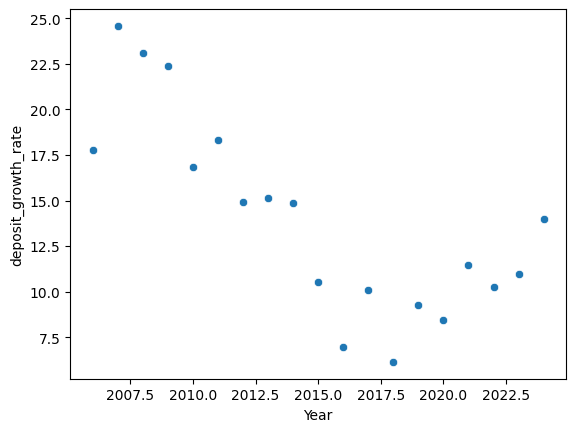

In [ ]:
#25 Visualizing only Scheduled Commercial Banks
data_nationalised = df1[df1["Banks"] == "ALL SCHEDULED COMMERCIAL BANKS"]
data_nationalised
sns.scatterplot(data = data_nationalised, x = "Year", y = "deposit_growth_rate")

<Axes: xlabel='Year', ylabel='HHI'>

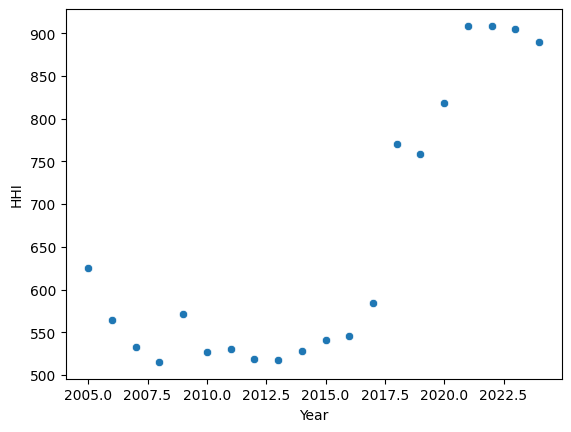

In [ ]:
#26 HHI Scatterplot
sns.scatterplot(data = hhi, x = "Year", y = "HHI")

In [ ]:
#27 Checking Column Names
df3 = df1.copy()
df3 = pd.merge(df3, ratios, on=['Banks','Year'], how='left')
for i in df3.columns:
    print(i)

Year
Banks
1.     Cash in hand
2.     Balances with RBI
3.     Balances with banks in India
4.     Money at call and short notice
5.     Balances with banks outside India
6.     Investments
6.1.       Investments in India
(i)     Government securities
(ii)    Other approved securities
(iii)   Shares
(iv)   Debentures and Bonds
(v)    Subsidiaries and/or joint ventures
(vi)   Others
6.2.       Investments outside India
(i)      Government securities
(ii)    Subsidiaries and/or joint ventures
(iii)   Others
7.     Advances
7A.1.    Bills purchased and discounted
7A.2.    Cash credits, overdrafts & loans
7A.3.    Term loans
7B.1.    Secured by tangible assets
7B.2.    Covered by Bank/Govt. Guarantees
7B.3.    Unsecured
7C.1.     Advances in India
(i)         Priority sectors 
(ii)        Public sectors
(iii)       Banks
(iv)       others
7C.2.    Advances outside India
8.     Fixed Assets
8.1.      Premises
8.2.      Fixed assets under construction
8.3.      Other Fixed assets
9.     Othe

In [ ]:
#28 Convert to MultiIndex (Fasten your seatbelts)
df3.set_index(['Banks', 'Year'], inplace=True)